# Seoul Bike Sharing Demand

## 1. Frame the problem

Nowadays rental bikes are a reality in the many urban cities in the world. One of the biggest
concerns is maintaining a reliable supply of bicycles to meet public demand regardless of time
and weather. However, the demand is not constant. It has, at least, seasonal fluctuation
depending where the city is in addition to hourly and weather fluctuations. The maintenance
schedule and the logistics of distribution of bicycles between locations are very important
due to the fluctuation on demand stated before.

Regarding the main concern presented, the data set I worked on contains the count
of public bikes rented at each hour in the Seoul Bike sharing System, besides weather
and holiday information. The main objective of this analysis is to build a model highly
interpretative where it will be possible to isolate the attributes that are mostly responsible
for the demand fluctuation. Even if the goal is interpretation, we would like to avoid
underfitting by simplicity and, of course, overfitting by high complexity. I believe that a
highly interpretive model is more actionable because it leads to more straight actions that
can change certain variables or use this variable in favor of something. In this specific
case, a highly interpretative model can lead to improvements on maintenance schedule, for
example.


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, OrthogonalMatchingPursuit

sns.set_theme(context='paper', style='white', palette='deep', 
              font='sans-serif', font_scale=1, color_codes=True, rc=None)

# 2. Get the data

In [2]:
raw_data = pd.read_csv('../data/raw/SeoulBikeData.csv', 
                       names=['date','rented_bike_count','hour','temp',
                              'hum','wind_speed','visib','dew_point_temp','solar_rad','rainfall','snowfall',
                              'season','holiday','func_day'], header=0)

In [3]:
raw_data.head()

,date,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall,season,holiday,func_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8760 non-null   object 
 1   rented_bike_count  8760 non-null   int64  
 2   hour               8760 non-null   int64  
 3   temp               8760 non-null   float64
 4   hum                8760 non-null   int64  
 5   wind_speed         8760 non-null   float64
 6   visib              8760 non-null   int64  
 7   dew_point_temp     8760 non-null   float64
 8   solar_rad          8760 non-null   float64
 9   rainfall           8760 non-null   float64
 10  snowfall           8760 non-null   float64
 11  season             8760 non-null   object 
 12  holiday            8760 non-null   object 
 13  func_day           8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [5]:
raw_data['date'] = pd.to_datetime(raw_data['date'])

In [6]:
raw_data.set_index(['date'], inplace=True)

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-12 to 2018-11-30
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rented_bike_count  8760 non-null   int64  
 1   hour               8760 non-null   int64  
 2   temp               8760 non-null   float64
 3   hum                8760 non-null   int64  
 4   wind_speed         8760 non-null   float64
 5   visib              8760 non-null   int64  
 6   dew_point_temp     8760 non-null   float64
 7   solar_rad          8760 non-null   float64
 8   rainfall           8760 non-null   float64
 9   snowfall           8760 non-null   float64
 10  season             8760 non-null   object 
 11  holiday            8760 non-null   object 
 12  func_day           8760 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage: 958.1+ KB


In [8]:
raw_data.describe()

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [9]:
raw_data.to_csv('../data/interim/seoul_bike_clean_data.csv')

# 3. EDA

In [10]:
eda_data = pd.read_csv('../data/interim/seoul_bike_clean_data.csv')

In [11]:
eda_data.loc[eda_data['func_day'] == 'No']

,date,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall,season,holiday,func_day
3144,2018-11-04,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No Holiday,No
3145,2018-11-04,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No Holiday,No
3146,2018-11-04,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No Holiday,No
3147,2018-11-04,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No Holiday,No
3148,2018-11-04,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No Holiday,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8251,2018-09-11,0,19,11.9,71,2.7,589,6.7,0.0,0.0,0.0,Autumn,No Holiday,No
8252,2018-09-11,0,20,11.9,72,2.5,526,7.0,0.0,0.0,0.0,Autumn,No Holiday,No
8253,2018-09-11,0,21,11.4,74,1.9,498,6.9,0.0,0.0,0.0,Autumn,No Holiday,No
8254,2018-09-11,0,22,11.2,75,1.7,478,6.9,0.0,0.0,0.0,Autumn,No Holiday,No


In [12]:
# stratified sampling
eda_data['rented_bike_count_cat'] = pd.cut(eda_data['rented_bike_count'], bins=5)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(eda_data, eda_data['rented_bike_count_cat']):
    train = eda_data.loc[train_index]
    test = eda_data.loc[test_index]

In [13]:
train['date'] = pd.to_datetime(train['date'])
train.set_index(['date'], inplace=True)

array([[<AxesSubplot:title={'center':'rented_bike_count'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'hum'}>,
        <AxesSubplot:title={'center':'wind_speed'}>,
        <AxesSubplot:title={'center':'visib'}>],
       [<AxesSubplot:title={'center':'dew_point_temp'}>,
        <AxesSubplot:title={'center':'solar_rad'}>,
        <AxesSubplot:title={'center':'rainfall'}>],
       [<AxesSubplot:title={'center':'snowfall'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

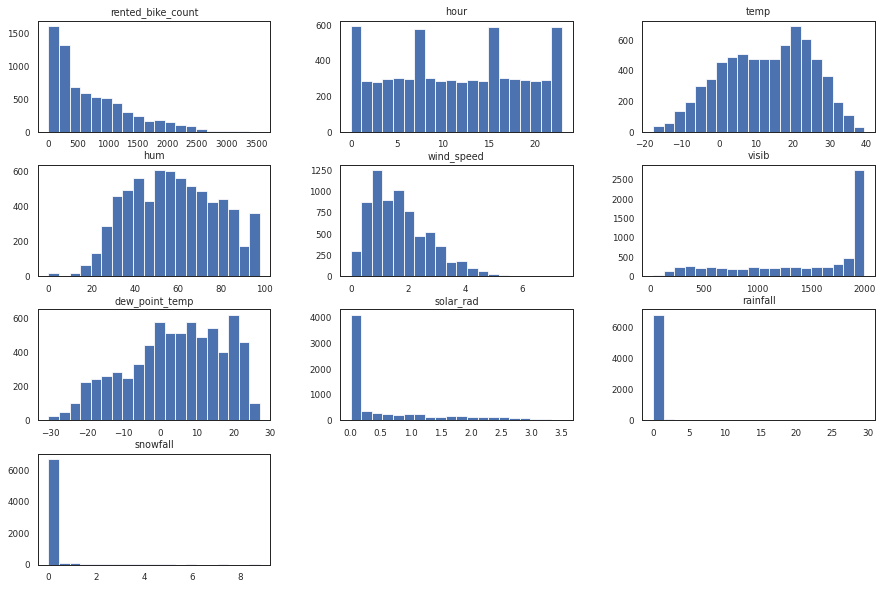

In [14]:
sns.set_style(style='white')
train.hist(figsize=(15, 10), bins=20, grid=False)

In [15]:
train_ = train.loc[train['func_day'] != 'No']

In [16]:
train_.describe()

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall
count,6767.000000,6767.000000,6767.000000,6767.000000,6767.000000,6767.000000,6767.000000,6767.000000,6767.000000,6767.000000
mean,729.776119,11.519580,12.735599,58.063544,1.725004,1436.191074,3.900783,0.566885,0.139752,0.078100
std,642.444092,6.936466,12.113068,20.461418,1.037101,608.225042,13.256309,0.866952,1.044693,0.435119
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,214.000000,5.500000,3.000000,42.000000,0.900000,936.000000,-5.100000,0.000000,0.000000,0.000000
50%,535.000000,12.000000,13.500000,57.000000,1.500000,1697.000000,4.700000,0.010000,0.000000,0.000000
75%,1088.000000,18.000000,22.600000,74.000000,2.300000,2000.000000,15.100000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,29.500000,8.800000


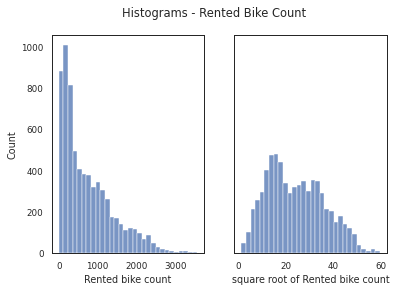

In [19]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].set_xlabel('Rented bike count')
axs[1].set_xlabel('square root of Rented bike count')
sns.histplot(data=train_, x='rented_bike_count', bins=30, ax=axs[0])
sns.histplot(data=np.sqrt(train_['rented_bike_count']), bins=30, ax=axs[1])
fig.suptitle('Histograms - Rented Bike Count')

plt.savefig('../report/figures/hist_target.png', dpi=400)

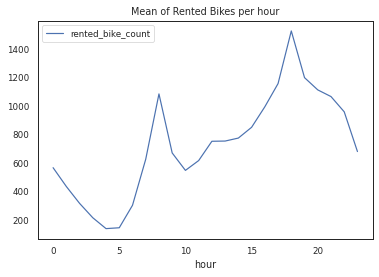

In [20]:
train_.groupby(['hour']).mean().plot(y='rented_bike_count', kind='line', title='Mean of Rented Bikes per hour')
plt.savefig('../report/figures/rented.png', dpi=400)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='hour', ylabel='rented_bike_count'>

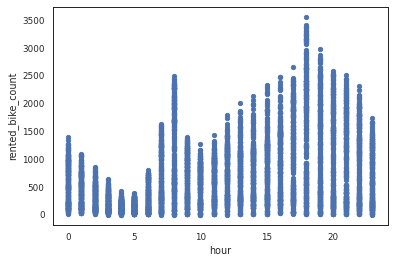

In [21]:
train_.plot(y='rented_bike_count', x='hour', kind='scatter')

In [22]:
train_.corr()

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall
rented_bike_count,1.000000,0.417369,0.561210,-0.199894,0.118164,0.213941,0.399658,0.275693,-0.129581,-0.154074
hour,0.417369,1.000000,0.109268,-0.240370,0.286733,0.106441,-0.008920,0.144155,0.015143,-0.016312
temp,0.561210,0.109268,1.000000,0.169400,-0.046321,0.032327,0.915510,0.351083,0.050269,-0.223903
hum,-0.199894,-0.240370,0.169400,1.000000,-0.342131,-0.547702,0.539437,-0.451472,0.239166,0.110273
wind_speed,0.118164,0.286733,-0.046321,-0.342131,1.000000,0.182998,-0.185310,0.330957,-0.037184,-0.004967
visib,0.213941,0.106441,0.032327,-0.547702,0.182998,1.000000,-0.178081,0.149685,-0.169992,-0.126941
dew_point_temp,0.399658,-0.008920,0.915510,0.539437,-0.185310,-0.178081,1.000000,0.099151,0.125661,-0.154868
solar_rad,0.275693,0.144155,0.351083,-0.451472,0.330957,0.149685,0.099151,1.000000,-0.074892,-0.072804
rainfall,-0.129581,0.015143,0.050269,0.239166,-0.037184,-0.169992,0.125661,-0.074892,1.000000,0.014040
snowfall,-0.154074,-0.016312,-0.223903,0.110273,-0.004967,-0.126941,-0.154868,-0.072804,0.014040,1.000000


dew_point_temp is highly correlated with temp (0.91), to avoid collinearity I dropped it

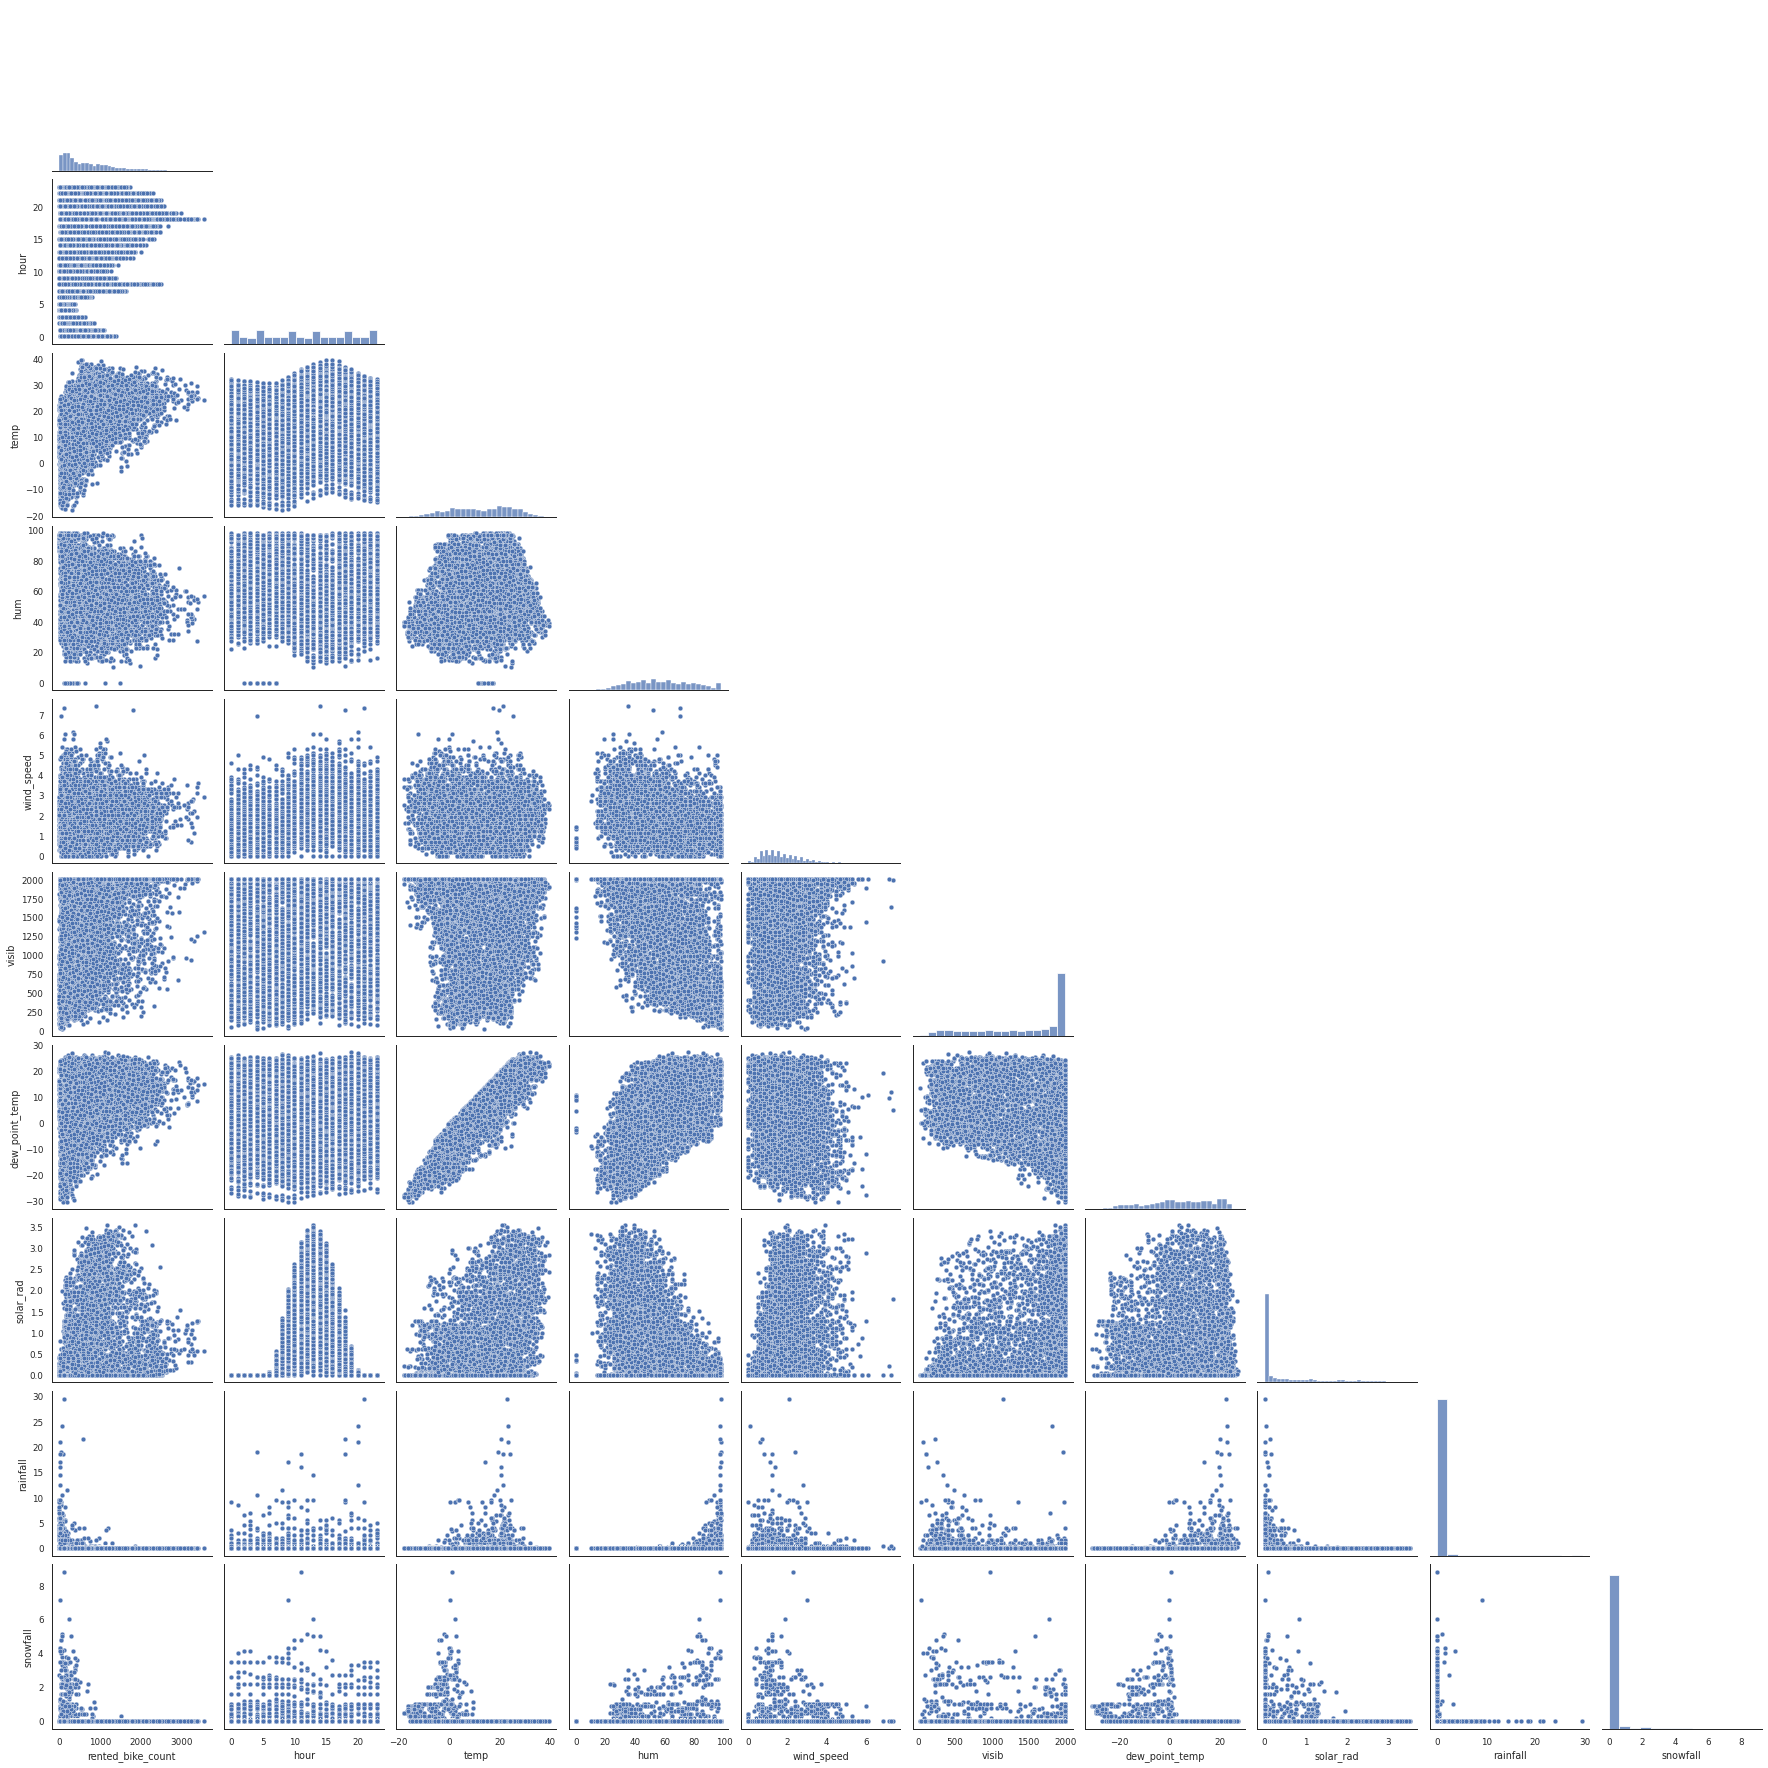

In [23]:
sns.pairplot(train_, corner=True)

In [24]:
train_.skew()

rented_bike_count     1.139549
hour                 -0.002496
temp                 -0.177533
hum                   0.070413
wind_speed            0.912603
visib                -0.696367
dew_point_temp       -0.339429
solar_rad             1.502587
rainfall             14.268859
snowfall              7.883960
dtype: float64

In [25]:
def skewed_transformation(df, threshold):
    log_df = df.copy()
    for col in df.skew().index:
        if np.abs(df.skew()[col]) > threshold:
            log_df['log_'+col] = np.log1p(df[col])
    return log_df

In [26]:
log_train = skewed_transformation(train, 0.4)

array([[<AxesSubplot:title={'center':'rented_bike_count'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'hum'}>],
       [<AxesSubplot:title={'center':'wind_speed'}>,
        <AxesSubplot:title={'center':'visib'}>,
        <AxesSubplot:title={'center':'dew_point_temp'}>,
        <AxesSubplot:title={'center':'solar_rad'}>],
       [<AxesSubplot:title={'center':'rainfall'}>,
        <AxesSubplot:title={'center':'snowfall'}>,
        <AxesSubplot:title={'center':'log_rented_bike_count'}>,
        <AxesSubplot:title={'center':'log_wind_speed'}>],
       [<AxesSubplot:title={'center':'log_visib'}>,
        <AxesSubplot:title={'center':'log_solar_rad'}>,
        <AxesSubplot:title={'center':'log_rainfall'}>,
        <AxesSubplot:title={'center':'log_snowfall'}>]], dtype=object)

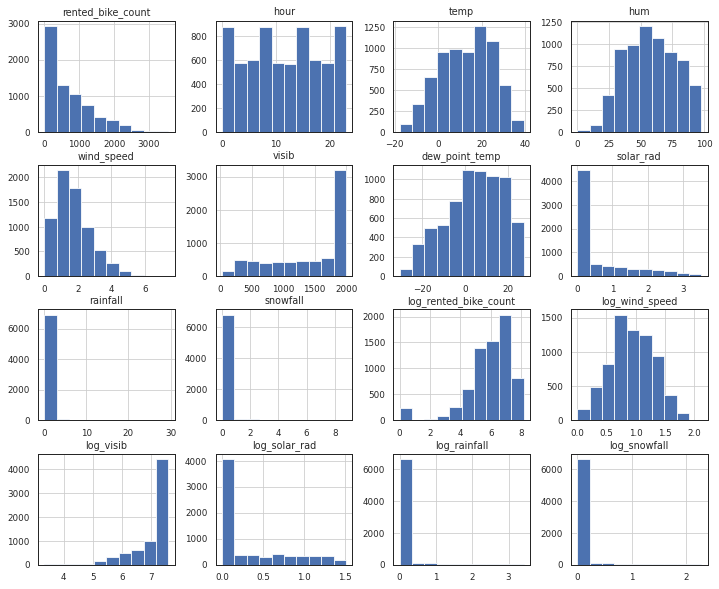

In [27]:
log_train.hist(figsize=(12, 10))

In [28]:
train.corr()

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall
rented_bike_count,1.000000,0.403206,0.535817,-0.197756,0.113736,0.201036,0.378210,0.262097,-0.124189,-0.143823
hour,0.403206,1.000000,0.111156,-0.246716,0.284889,0.102772,-0.010385,0.145203,0.007713,-0.015732
temp,0.535817,0.111156,1.000000,0.162019,-0.043224,0.039307,0.913799,0.350156,0.048120,-0.224625
hum,-0.197756,-0.246716,0.162019,1.000000,-0.341427,-0.543239,0.536764,-0.456348,0.238848,0.108229
wind_speed,0.113736,0.284889,-0.043224,-0.341427,1.000000,0.174057,-0.183882,0.337240,-0.029852,-0.004793
visib,0.201036,0.102772,0.039307,-0.543239,0.174057,1.000000,-0.172189,0.147147,-0.166774,-0.125646
dew_point_temp,0.378210,-0.010385,0.913799,0.536764,-0.183882,-0.172189,1.000000,0.095314,0.124287,-0.156086
solar_rad,0.262097,0.145203,0.350156,-0.456348,0.337240,0.147147,0.095314,1.000000,-0.075326,-0.071866
rainfall,-0.124189,0.007713,0.048120,0.238848,-0.029852,-0.166774,0.124287,-0.075326,1.000000,0.013502
snowfall,-0.143823,-0.015732,-0.224625,0.108229,-0.004793,-0.125646,-0.156086,-0.071866,0.013502,1.000000


In [29]:
log_corr = log_train.corr()
log_corr

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall,log_rented_bike_count,log_wind_speed,log_visib,log_solar_rad,log_rainfall,log_snowfall
rented_bike_count,1.000000,0.403206,0.535817,-0.197756,0.113736,0.201036,0.378210,0.262097,-0.124189,-0.143823,0.741755,0.143311,0.219390,0.284931,-0.180175,-0.164344
hour,0.403206,1.000000,0.111156,-0.246716,0.284889,0.102772,-0.010385,0.145203,0.007713,-0.015732,0.264216,0.299856,0.104544,0.163867,-0.000374,-0.018507
temp,0.535817,0.111156,1.000000,0.162019,-0.043224,0.039307,0.913799,0.350156,0.048120,-0.224625,0.361213,-0.021178,0.061765,0.342325,0.064063,-0.270204
hum,-0.197756,-0.246716,0.162019,1.000000,-0.341427,-0.543239,0.536764,-0.456348,0.238848,0.108229,-0.209014,-0.350012,-0.551139,-0.469011,0.344133,0.094527
wind_speed,0.113736,0.284889,-0.043224,-0.341427,1.000000,0.174057,-0.183882,0.337240,-0.029852,-0.004793,0.068930,0.973793,0.167832,0.352808,-0.038141,0.012842
visib,0.201036,0.102772,0.039307,-0.543239,0.174057,1.000000,-0.172189,0.147147,-0.166774,-0.125646,0.159693,0.172990,0.955774,0.148782,-0.235708,-0.120772
dew_point_temp,0.378210,-0.010385,0.913799,0.536764,-0.183882,-0.172189,1.000000,0.095314,0.124287,-0.156086,0.227960,-0.168389,-0.151386,0.084833,0.175056,-0.199412
solar_rad,0.262097,0.145203,0.350156,-0.456348,0.337240,0.147147,0.095314,1.000000,-0.075326,-0.071866,0.239397,0.350797,0.168512,0.984624,-0.109261,-0.080456
rainfall,-0.124189,0.007713,0.048120,0.238848,-0.029852,-0.166774,0.124287,-0.075326,1.000000,0.013502,-0.186823,-0.031293,-0.198194,-0.077975,0.881587,0.001072
snowfall,-0.143823,-0.015732,-0.224625,0.108229,-0.004793,-0.125646,-0.156086,-0.071866,0.013502,1.000000,-0.109890,-0.004469,-0.153838,-0.068485,0.019876,0.968535


In [30]:
log_train['rented_bc'] = np.sqrt(log_train['rented_bike_count'])

In [31]:
log_corr = log_train.corr()
log_corr

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall,log_rented_bike_count,log_wind_speed,log_visib,log_solar_rad,log_rainfall,log_snowfall,rented_bc
rented_bike_count,1.000000,0.403206,0.535817,-0.197756,0.113736,0.201036,0.378210,0.262097,-0.124189,-0.143823,0.741755,0.143311,0.219390,0.284931,-0.180175,-0.164344,0.962122
hour,0.403206,1.000000,0.111156,-0.246716,0.284889,0.102772,-0.010385,0.145203,0.007713,-0.015732,0.264216,0.299856,0.104544,0.163867,-0.000374,-0.018507,0.383085
temp,0.535817,0.111156,1.000000,0.162019,-0.043224,0.039307,0.913799,0.350156,0.048120,-0.224625,0.361213,-0.021178,0.061765,0.342325,0.064063,-0.270204,0.535875
hum,-0.197756,-0.246716,0.162019,1.000000,-0.341427,-0.543239,0.536764,-0.456348,0.238848,0.108229,-0.209014,-0.350012,-0.551139,-0.469011,0.344133,0.094527,-0.224333
wind_speed,0.113736,0.284889,-0.043224,-0.341427,1.000000,0.174057,-0.183882,0.337240,-0.029852,-0.004793,0.068930,0.973793,0.167832,0.352808,-0.038141,0.012842,0.104255
visib,0.201036,0.102772,0.039307,-0.543239,0.174057,1.000000,-0.172189,0.147147,-0.166774,-0.125646,0.159693,0.172990,0.955774,0.148782,-0.235708,-0.120772,0.205653
dew_point_temp,0.378210,-0.010385,0.913799,0.536764,-0.183882,-0.172189,1.000000,0.095314,0.124287,-0.156086,0.227960,-0.168389,-0.151386,0.084833,0.175056,-0.199412,0.369100
solar_rad,0.262097,0.145203,0.350156,-0.456348,0.337240,0.147147,0.095314,1.000000,-0.075326,-0.071866,0.239397,0.350797,0.168512,0.984624,-0.109261,-0.080456,0.301963
rainfall,-0.124189,0.007713,0.048120,0.238848,-0.029852,-0.166774,0.124287,-0.075326,1.000000,0.013502,-0.186823,-0.031293,-0.198194,-0.077975,0.881587,0.001072,-0.165954
snowfall,-0.143823,-0.015732,-0.224625,0.108229,-0.004793,-0.125646,-0.156086,-0.071866,0.013502,1.000000,-0.109890,-0.004469,-0.153838,-0.068485,0.019876,0.968535,-0.155519


In [32]:
log_train.describe()

,rented_bike_count,hour,temp,hum,wind_speed,visib,dew_point_temp,solar_rad,rainfall,snowfall,log_rented_bike_count,log_wind_speed,log_visib,log_solar_rad,log_rainfall,log_snowfall,rented_bc
count,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000
mean,704.679652,11.508134,12.856421,58.145691,1.724586,1438.952768,4.038128,0.569045,0.140611,0.075414,5.886758,0.932450,7.120805,0.333414,0.054252,0.041216,23.445650
std,645.155985,6.935034,11.952932,20.341091,1.040062,607.372439,13.072701,0.867853,1.055691,0.427807,1.584087,0.374392,0.643807,0.452376,0.272870,0.202416,12.450031
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,3.332205,0.000000,0.000000,0.000000,0.000000
25%,192.000000,5.000000,3.400000,42.000000,0.900000,941.750000,-4.625000,0.000000,0.000000,0.000000,5.262690,0.641854,6.848801,0.000000,0.000000,0.000000,13.856406
50%,500.500000,11.000000,13.800000,57.000000,1.500000,1703.500000,5.100000,0.010000,0.000000,0.000000,6.217603,0.916291,7.441027,0.009950,0.000000,0.000000,22.371855
75%,1068.000000,18.000000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.940000,0.000000,0.000000,6.974479,1.193922,7.601402,0.662688,0.000000,0.000000,32.680269
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,29.500000,8.800000,8.176673,2.128232,7.601402,1.508512,3.417727,2.282382,59.632206


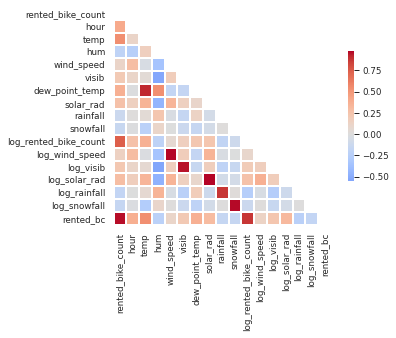

In [33]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(log_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots()

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(log_corr, mask=mask, cmap=plt.get_cmap('coolwarm'), center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .6})

plt.savefig('../report/figures/heatmap.png', dpi=400)

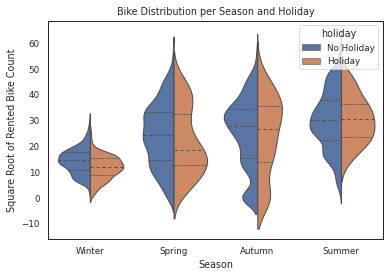

In [34]:
fig, ax = plt.subplots(1, 1)
sns.violinplot(data=log_train, x='season', y='rented_bc', hue='holiday',
               split=True, inner="quart", linewidth=1)
ax.set_ylabel('Square Root of Rented Bike Count')
ax.set_xlabel('Season')
ax.set_title('Bike Distribution per Season and Holiday')
plt.savefig('../report/figures/violin.png', dpi=400)

In [35]:
log_train.groupby(['season'])[['rented_bike_count']].agg(['mean', 'median','std', 'count'])

rented_bike_count                         
                    mean median         std count
season                                           
Autumn        822.300113  768.0  653.720651  1766
Spring        733.845361  586.0  620.478261  1746
Summer       1031.417426  902.5  691.821057  1756
Winter        226.293103  204.0  149.466262  1740

In [36]:
log_train.groupby(['holiday'])[['rented_bike_count']].agg(['mean', 'median','std', 'count'])

rented_bike_count                         
                        mean median         std count
holiday                                              
Holiday           515.733918    248  583.194974   342
No Holiday        714.373537    520  646.727771  6666

In [37]:
log_train.groupby([log_train.index.day_of_week])[['rented_bike_count']].agg(['mean', 'median','std', 'count'])

rented_bike_count                         
                  mean median         std count
date                                           
0           728.579002  521.0  681.853562   962
1           678.097512  476.0  622.806532  1005
2           710.863859  484.0  657.140769  1021
3           734.664000  563.0  635.252198  1000
4           746.558376  562.0  676.269614   985
5           728.704885  526.0  634.004087  1003
6           609.793605  390.5  599.117647  1032

drop func_day == No and the column

# 4. Data preparation

0. reset_index
1. Drop rows: func_day == No
2. Drop Columns: func_day and dew_point_temp, date, rented_bike_count_cat
3. Logs: wind_speed, solar_rad, rainfall, snowfall
4. Standard Scale
5. OneHot Season and holiday
6. sqrt y

In [38]:
for train_index, test_index in sss.split(eda_data, eda_data['rented_bike_count_cat']):
    train = eda_data.loc[train_index]
    test = eda_data.loc[test_index]

In [39]:
def first_pipeline(df):
    df = df.loc[df['func_day'] != 'No']
    df = df.drop(['func_day', 'date', 'dew_point_temp', 'rented_bike_count_cat'], axis=1)
    mask = [col in (['wind_speed', 'solar_rad', 'rainfall', 'snowfall', 'visib']) for col in df.columns]
    df.loc[:,mask] = df.loc[:,mask].apply(lambda x: np.log1p(x), axis=1)
    X = df.drop(['rented_bike_count'], axis=1)
    y = np.sqrt(df['rented_bike_count'])
    return X, y

In [40]:
X, y = first_pipeline(train)

In [41]:
# numerical
num_att = list(X.loc[:,list(X.dtypes != 'object')].columns)
# categorical
cat_att = list(X.loc[:,list(X.dtypes == 'object')].columns)

pipe_num = Pipeline([
    ('scaler', StandardScaler()),
    ('Poly', PolynomialFeatures(degree=3, include_bias=False))
])

pipe_cat = Pipeline([
    ('encoding', OneHotEncoder(drop='first'))
])
full_pipe = ColumnTransformer([
    ('num', pipe_num, num_att),
    ('cat', pipe_cat, cat_att)
])

In [42]:
X = full_pipe.fit_transform(X)

# 5. Modeling

- Linear Regression
    - Basic Model
- Lasso
    - The data set is not huge and the model is more interpretable 
- ElasticNet
    - half way between Lasso and Ridge

- OrthogonalMatchingPursuit
     - constraints imposed on the number of non-zero coefficients (ie. the pseudo-norm).

In [43]:
lr = LinearRegression()
lasso = Lasso(random_state=0, max_iter=10000)
elasticn = ElasticNet(random_state=0, max_iter=10000)
omp = OrthogonalMatchingPursuit()

In [44]:
param_lr = {'fit_intercept': [True, False],
           'normalize': [True, False]}
lr_cv = GridSearchCV(lr, n_jobs=-1, param_grid=param_lr, scoring='r2', return_train_score=True)
lr_cv.fit(X, y)

GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             return_train_score=True, scoring='r2')

In [45]:
lr_cv.best_estimator_, lr_cv.best_score_

(LinearRegression(normalize=True), 0.794333920249515)

In [46]:
param_las = {'alpha': np.geomspace(0.00001, 1, 10),
              'fit_intercept': [True, False]}
las_cv = GridSearchCV(lasso, n_jobs=-1, param_grid=param_las, scoring='r2', return_train_score=True)
las_cv.fit(X, y)

GridSearchCV(estimator=Lasso(max_iter=10000, random_state=0), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 3.59381366e-05, 1.29154967e-04, 4.64158883e-04,
       1.66810054e-03, 5.99484250e-03, 2.15443469e-02, 7.74263683e-02,
       2.78255940e-01, 1.00000000e+00]),
                         'fit_intercept': [True, False]},
             return_train_score=True, scoring='r2')

In [47]:
las_cv.best_estimator_, las_cv.best_score_

(Lasso(alpha=0.005994842503189409, max_iter=10000, random_state=0),
 0.8152767338070482)

In [48]:
param_elas = {'alpha': np.geomspace(0.00001, 1, 10),
              'fit_intercept': [True, False],
             'l1_ratio': np.geomspace(0.1, 1, 5)}
elas_cv = GridSearchCV(elasticn, n_jobs=-1, param_grid=param_elas, scoring='r2', return_train_score=True)
elas_cv.fit(X, y)

GridSearchCV(estimator=ElasticNet(max_iter=10000, random_state=0), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 3.59381366e-05, 1.29154967e-04, 4.64158883e-04,
       1.66810054e-03, 5.99484250e-03, 2.15443469e-02, 7.74263683e-02,
       2.78255940e-01, 1.00000000e+00]),
                         'fit_intercept': [True, False],
                         'l1_ratio': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ])},
             return_train_score=True, scoring='r2')

In [49]:
elas_cv.best_estimator_, elas_cv.best_score_

(ElasticNet(alpha=0.005994842503189409, l1_ratio=1.0, max_iter=10000,
            random_state=0),
 0.8152767338070482)

ElasticNet Just fit the l1_ratio to 1, thus it is the same model as Lasso.

In [50]:
param_omp = {'n_nonzero_coefs': np.arange(50, 170, 5)}
omp_cv = GridSearchCV(omp, n_jobs=-1, param_grid=param_omp, scoring='r2', return_train_score=True)
omp_cv.fit(X, y)

GridSearchCV(estimator=OrthogonalMatchingPursuit(), n_jobs=-1,
             param_grid={'n_nonzero_coefs': array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165])},
             return_train_score=True, scoring='r2')

In [51]:
omp_cv.best_estimator_, omp_cv.best_score_

(OrthogonalMatchingPursuit(n_nonzero_coefs=155), 0.8144340045883783)

In [52]:
omp_cv.cv_results_

{'mean_fit_time': array([0.05599437, 0.04589744, 0.05444183, 0.04723511, 0.04667969,
        0.04313784, 0.04460745, 0.04633489, 0.04356861, 0.04224844,
        0.04449954, 0.04306159, 0.04655352, 0.04930329, 0.04455605,
        0.04326167, 0.04519591, 0.04455495, 0.04516711, 0.04334846,
        0.04722619, 0.05080533, 0.04647932, 0.04139838]),
 'std_fit_time': array([0.01345081, 0.01419165, 0.0181527 , 0.00643009, 0.00956273,
        0.00161972, 0.00471285, 0.00505943, 0.00020049, 0.00128501,
        0.00655563, 0.00235924, 0.00603285, 0.00610483, 0.00280942,
        0.00204309, 0.00112599, 0.00113526, 0.0014394 , 0.0018792 ,
        0.00183512, 0.00710649, 0.00987407, 0.00279825]),
 'mean_score_time': array([0.00303483, 0.00179834, 0.00156136, 0.00141521, 0.00168991,
        0.00171142, 0.00181918, 0.00184035, 0.00167961, 0.00152779,
        0.00182552, 0.00196013, 0.00207763, 0.00203471, 0.00180597,
        0.00197916, 0.0018374 , 0.00180683, 0.0018065 , 0.00200295,
        0.001900

In [53]:
omp_best = omp_cv.best_estimator_
lasso_best = las_cv.best_estimator_

# 6. Fine-tune the model

_ omp
_ lasso

In [54]:
np.sum(np.abs(omp_best.coef_)), np.sum(np.abs(lasso_best.coef_)), np.shape(omp_best.coef_), np.shape(lasso_best.coef_)

(154.24225016623194, 126.0955251951521, (168,), (168,))

In [55]:
list(omp_best.coef_).count(0)

13

In [56]:
list(lasso_best.coef_).count(0)

28

In [57]:
X_test, y_test = first_pipeline(test)
X_test = full_pipe.transform(X_test)

In [58]:
omp_best.score(X_test, y_test)

0.8118410255986154

In [59]:
lasso_best.score(X_test, y_test)

0.8156328486574298

In [60]:
lr_cv.best_estimator_.score(X_test, y_test)

0.8119401097132334

In [61]:
feat_names = full_pipe.named_transformers_['num']['Poly'].get_feature_names()
feat_names.extend(list(full_pipe.named_transformers_['cat']['encoding'].get_feature_names()))
feat_names

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x6^2',
 'x6 x7',
 'x7^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0^2 x5',
 'x0^2 x6',
 'x0^2 x7',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x1 x5',
 'x0 x1 x6',
 'x0 x1 x7',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x2 x5',
 'x0 x2 x6',
 'x0 x2 x7',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x3 x5',
 'x0 x3 x6',
 'x0 x3 x7',
 'x0 x4^2',
 'x0 x4 x5',
 'x0 x4 x6',
 'x0 x4 x7',
 'x0 x5^2',
 'x0 x5 x6',
 'x0 x5 x7',
 'x0 x6^2',
 'x0 x6 x7',
 'x0 x7^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1^2 x5',
 'x1^2 x6',
 'x1^2 x7',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x2 x5',
 'x1 x2 x6

In [62]:
pd.set_option('display.max_rows', 200)
pd.DataFrame(zip(feat_names, list(omp_best.coef_))).sort_values(by=1, ascending=True)

,0,1
6,x6,-12.424726
13,x0 x5,-10.924954
166,x0_Winter,-6.329520
38,x5^2,-4.110797
44,x0^3,-3.749218
164,x0_Spring,-3.618721
80,x1^3,-1.811254
16,x1^2,-1.786166
23,x2^2,-1.721689
10,x0 x2,-1.652080


In [63]:
pd.DataFrame(zip(feat_names, list(lasso_best.coef_))).sort_values(by=1, ascending=True)

,0,1
13,x0 x5,-10.331628
6,x6,-10.210335
166,x0_Winter,-6.220760
38,x5^2,-3.858453
44,x0^3,-3.622176
164,x0_Spring,-3.421702
10,x0 x2,-1.809398
16,x1^2,-1.799285
23,x2^2,-1.777082
80,x1^3,-1.732050


In [64]:
col_names = first_pipeline(test)[0]
pd.DataFrame(zip(list(col_names[num_att].columns), ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']))

,0,1
0,hour,x0
1,temp,x1
2,hum,x2
3,wind_speed,x3
4,visib,x4
5,solar_rad,x5
6,rainfall,x6
7,snowfall,x7
